## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration and distortion correction

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objPoints = [] # 3d points in real world space
imgPoints = [] # 2d points in image plane.
imgShape = (None,None)

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
#     print(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objPoints.append(objp)
        imgPoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         plt.imshow(img) 
#         plt.show()

# do camera calibration and image distortion correction
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, img.shape[1::-1], None, None)

img = cv2.imread("camera_cal/calibration2.jpg")
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('output_images/undistortion.jpg')

### do it on the test image

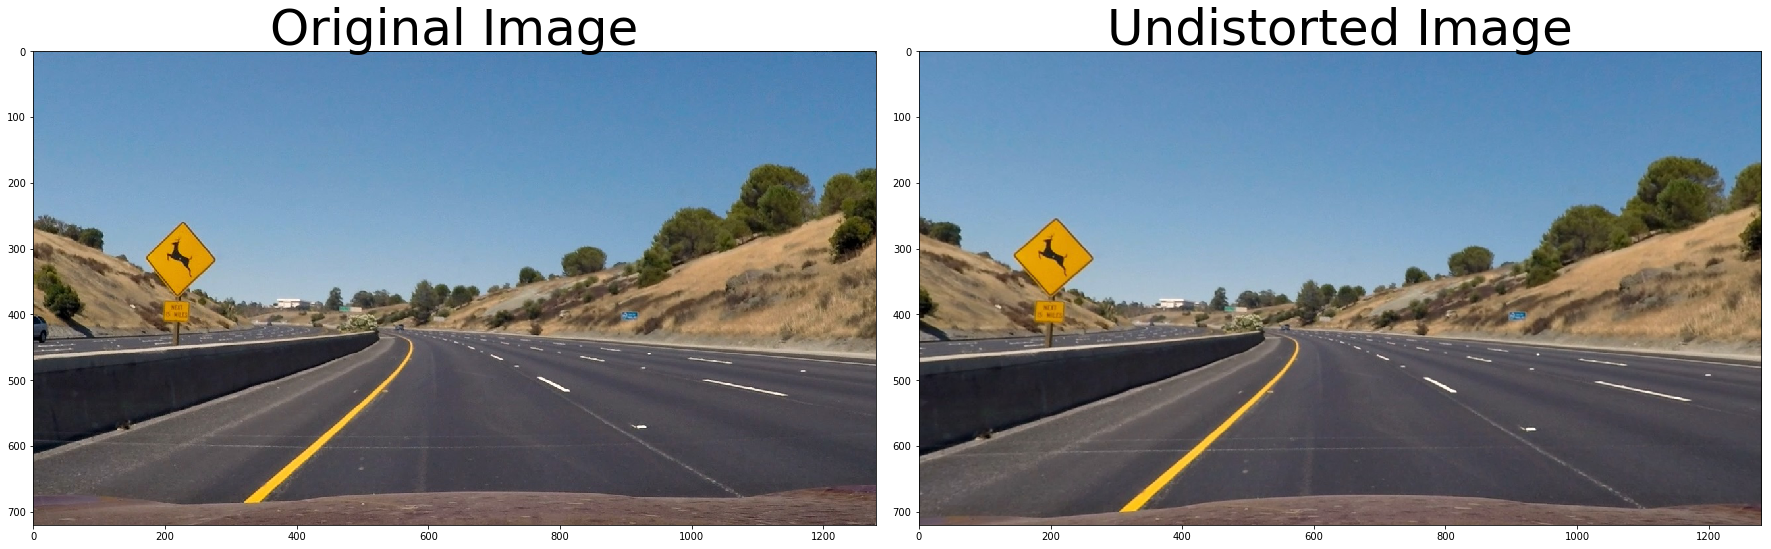

In [2]:
img_name = 'test2'
save_fig_flag = False # whether to save the fig to output_images or not

img = mpimg.imread('test_images/'+img_name+'.jpg')
undistortedImg = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistortedImg)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
if save_fig_flag:
    f.savefig('output_images/undistortion_'+img_name+'.jpg')

## Color transforms and gradients

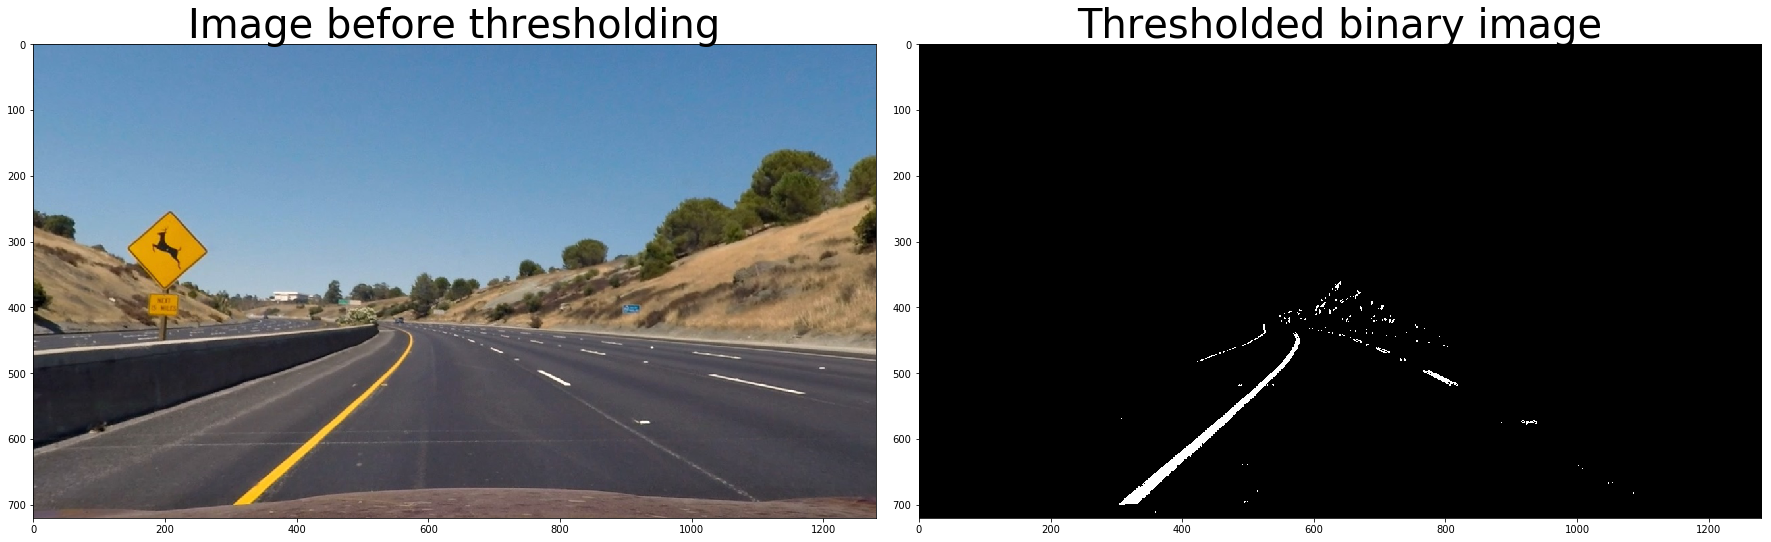

In [3]:
def apply_color_transforms_and_gradients(img, s_thresh=(170, 255), sx_thresh=(50, 200)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Combine two thres
    color_binary = (sxbinary | s_binary) * 255
    
    # Region of interest mask
    height = img.shape[0]
    width = img.shape[1]
    mask = np.zeros_like(color_binary)
    ROI_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [ROI_vertices], 1)
    return color_binary & mask

colorAndGradAppliedImg = apply_color_transforms_and_gradients(undistortedImg)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistortedImg)
ax1.set_title('Image before thresholding', fontsize=40)

ax2.imshow(colorAndGradAppliedImg, cmap='gray')
ax2.set_title('Thresholded binary image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if save_fig_flag:
    f.savefig('output_images/thresholding_'+img_name+'.jpg')

## Perspective transform 

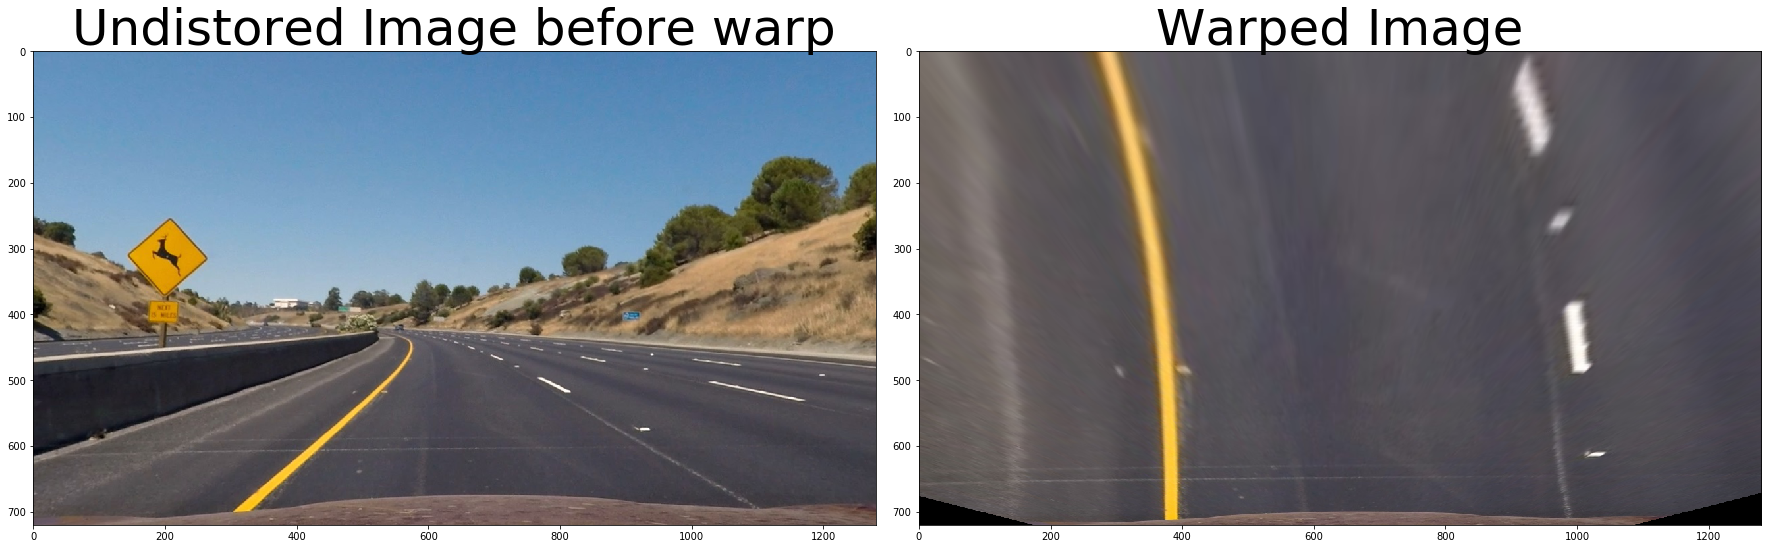

In [4]:
img_rect_vertices = np.float32([(578, 460), (203, 720), (1106, 720), (702, 460)])
real_rect_vertices = np.float32([(320, 0), (320, 720), (960, 720), (960, 0)])
# plt.imshow(undistortedImg)
# plt.plot(578, 460,'.')
# plt.plot(203, 720,'.')
# plt.plot(1106, 720,'.')
# plt.plot(702, 460,'.')
# plt.savefig('output_images/get_rect_on_straight_lanes.jpg')

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(img_rect_vertices, real_rect_vertices)
# Get the inverse values for later use
Minv = cv2.getPerspectiveTransform(real_rect_vertices, img_rect_vertices)
# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(undistortedImg, M, undistortedImg.shape[1::-1], flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistortedImg)
ax1.set_title('Undistored Image before warp', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
if save_fig_flag:
    f.savefig('output_images/warped_'+img_name+'.jpg')

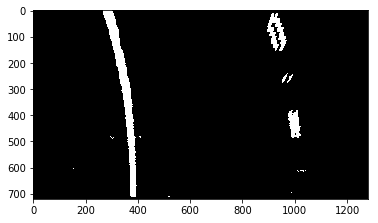

In [6]:
binary_warped = cv2.warpPerspective(colorAndGradAppliedImg, M, colorAndGradAppliedImg.shape[1::-1], flags=cv2.INTER_LINEAR)
plt.imshow(binary_warped, cmap='gray')
if save_fig_flag:
    plt.savefig('output_images/binary_warped_'+img_name+'.jpg')

## Find lanes

[ -2.29162532e-04   2.97598581e-01   2.84624648e+02]
[ -9.62366654e-05   2.41359287e-01   9.11625299e+02]


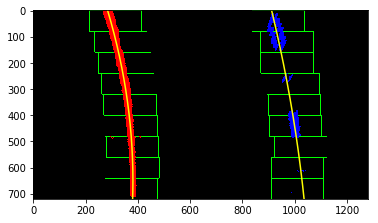

In [6]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img
        
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ## Visualization for sliding window ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    ## Visualization for final mask ##
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    return out_img, color_warp, left_fit, right_fit, ploty

out_img, out_mask, left_fit, right_fit, ploty = fit_polynomial(binary_warped)
plt.imshow(out_img)
if save_fig_flag:
    plt.savefig('output_images/sliding_windows_'+img_name+'.jpg')
print(left_fit)
print(right_fit)

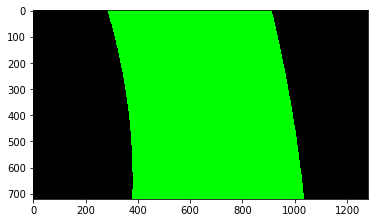

In [7]:
plt.imshow(out_mask)
if save_fig_flag:
    plt.savefig('output_images/output_mask_'+img_name+'.jpg')

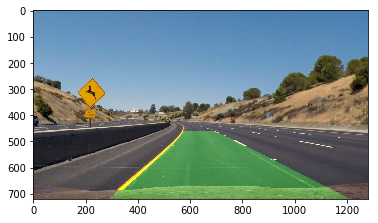

In [8]:
# inverse perspective transform
undistored_mask = cv2.warpPerspective(out_mask, Minv, out_mask.shape[1::-1], flags=cv2.INTER_LINEAR)
final_result = cv2.addWeighted(img, 1, undistored_mask, 0.3, 0)
plt.imshow(final_result)
if save_fig_flag:
    plt.savefig('output_images/final_image_'+img_name+'.jpg')

## Determine the curvature of the lane and vehicle position

In [9]:
def measure_curvature_real(left_fit, right_fit, ploty, center_pixel):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    ## Find vehicle center offset
    left_x_eval = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_x_eval = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    offset = ((left_x_eval+right_x_eval)/2-center_pixel)*xm_per_pix

    # scale fitting parameters for ax^2 + bx +c
    scale_a = xm_per_pix / (ym_per_pix ** 2)
    scale_b = xm_per_pix / ym_per_pix
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*scale_a*y_eval*ym_per_pix + left_fit[1]*scale_b)**2)**1.5) / np.absolute(2*left_fit[0]*scale_a)
    right_curverad = ((1 + (2*right_fit[0]*scale_a*y_eval*ym_per_pix + right_fit[1]*scale_b)**2)**1.5) / np.absolute(2*right_fit[0]*scale_a)
    
    return left_curverad, right_curverad, offset

center_pixel = binary_warped.shape[1]//2
# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, offset = measure_curvature_real(left_fit, right_fit, ploty, center_pixel)

print('average curvature:', (left_curverad+right_curverad)/2, 'm')
print('vehicle offset to the right of center:', offset, 'm')


average curvature: 1211.79060308 m
vehicle offset to the right of center: 0.358218036831 m


## Full pipeline
### I reorganized the code above to make it a class to be used for video output

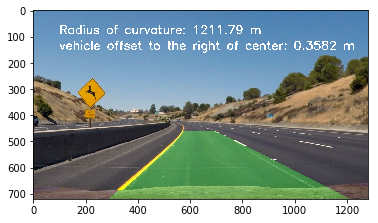

In [10]:
class Pipeline:
    def __init__(self):
        # list to store left (right) lane fit data
        self.left_fit_data = []
        self.right_fit_data = []
        # camera calibration parameters
        self.mtx, self.dist = self.calibrate_camera()
        # get perspective transformation needed parameters
        self.M, self.Minv = self.get_perspective_trans_matrices()
#         # num of consecutive bad detections
#         self.conse_bad_num = 0
#         # max num of consecutive bad detections endurable before resetting to use sliding window method
#         self.conse_bad_max = 10

    def calibrate_camera(self):
        '''
        do camera calibration given the chessboard images
        :param:
        :return: mtx, 3x3 floating-point camera matrix
        :return: dist, vector of distortion coefficients
        '''
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
        
        # Arrays to store object points and image points from all the images.
        objPoints = [] # 3d points in real world space
        imgPoints = [] # 2d points in image plane.
        imgShape = (None,None)

        # Make a list of calibration images
        images = glob.glob('camera_cal/calibration*.jpg')

        # Step through the list and search for chessboard corners
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
            # If found, add object points, image points
            if ret == True:
                objPoints.append(objp)
                imgPoints.append(corners)
        # do camera calibration and image distortion correction
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, img.shape[1::-1], None, None)
        
        # 
        return mtx, dist
    
    def get_perspective_trans_matrices(self):
        '''
        do perspective transformation and get parameters
        :param: 
        :return: M, perspective transform matrix
        :return: Minv, inverse perspective transform matrix
        '''
        # hard-coded values by experiments on straight lane image, see output_images/get_rect_on_straight_lanes.jpg
        img_rect_vertices = np.float32([(578, 460), (203, 720), (1106, 720), (702, 460)])
        real_rect_vertices = np.float32([(320, 0), (320, 720), (960, 720), (960, 0)])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(img_rect_vertices, real_rect_vertices)
        # Get the inverse values for later use
        Minv = cv2.getPerspectiveTransform(real_rect_vertices, img_rect_vertices)
        return M, Minv
    
    def apply_color_transforms_and_gradients(self, image, s_thresh=(170, 255), sx_thresh=(50, 200)):
        '''
        do thresholding based on color channels and x-direction sobel gradients
        :param: image, undistored image
        :param: s_thresh, color threshold on s channel
        :param: sx_thresh, sobel x threshold on l channel
        :return: mtx, 3x3 floating-point camera matrix
        :return: combination of thresholds and ROI (binary) mask
        '''
        img = np.copy(image)
        # Convert to HLS color space and separate the V channel
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        # Combine two thres
        color_binary = (sxbinary | s_binary) * 255

        # Region of interest mask
        height = img.shape[0]
        width = img.shape[1]
        mask = np.zeros_like(color_binary)
        ROI_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
        cv2.fillPoly(mask, [ROI_vertices], 1)
        return color_binary & mask
    
    def find_lane_pixels(self, binary_warped):
        '''
        use sliding window to find lane pixels
        :param: binary warped image
        :return: leftx, lefty, rightx, righty are positions of detected lane pixels
        '''
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### TO-DO: Find the four below boundaries of the window ###
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            ### Identify the nonzero pixels in x and y within the window ###
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            ### If you found > minpix pixels, recenter next window ###
            ### (`right` or `leftx_current`) on their mean position ###
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty
    
    def search_around_poly(self, binary_warped):
        '''
        use cached window with margin to find lane pixels
        :param: binary warped image
        :return: leftx, lefty, rightx, righty are positions of detected lane pixels
        '''
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        left_lane_inds = ((nonzerox > (self.left_fit_data[-1][0]*(nonzeroy**2) + self.left_fit_data[-1][1]*nonzeroy + 
                        self.left_fit_data[-1][2] - margin)) & (nonzerox < (self.left_fit_data[-1][0]*(nonzeroy**2) + 
                        self.left_fit_data[-1][1]*nonzeroy + self.left_fit_data[-1][2] + margin)))
        right_lane_inds = ((nonzerox > (self.right_fit_data[-1][0]*(nonzeroy**2) + self.right_fit_data[-1][1]*nonzeroy + 
                        self.right_fit_data[-1][2] - margin)) & (nonzerox < (self.right_fit_data[-1][0]*(nonzeroy**2) + 
                        self.right_fit_data[-1][1]*nonzeroy + self.right_fit_data[-1][2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        return leftx, lefty, rightx, righty
        
    def fit_polynomial(self, binary_warped, leftx, lefty, rightx, righty):
        '''
        fit polynomial to the detected lane pixels, also do quality control and call curvature measure function
        :param: binary warped image + output from lane pixel finding results
        :return: left_fitx, right_fitx, ploty are info of points of fitted polynomials
        :return: curverad_str, offset_str, curvature and offset messages to plot
        '''
        ### Fit a second order polynomial to each using `np.polyfit` ###
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        
        # Here we do a quick calculation of curvature (not using real units) to evaluate the quality of detection
        y_eval = np.max(ploty)
        left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#         # We should have left and right curvatures in a similar range
#         # We should have left and right curve have the same sign for a for ax^2+bx+c
#         # Otherwise, we either use data from previous frames or reset to use silding window for the next frame
#         if abs(left_curverad/right_curverad)<0.1 or abs(left_curverad/right_curverad)>10 or left_fit[0]*right_fit[0]<0:
#             if self.conse_bad_num >= self.conse_bad_max:
#                 # reset
#                 # print("Not a good detection on this frame, will reset to use SlidingWindow for incoming frames\n")
#                 self.conse_bad_num = 0
#                 self.left_fit_data = []
#                 self.right_fit_data = []
#             elif self.left_fit_data and self.right_fit_data:
#                 # use data from last frame (if we have a last good frame)
#                 left_fit = self.left_fit_data[-1]
#                 right_fit = self.right_fit_data[-1]
#                 self.conse_bad_num += 1       
#             else:
#                 self.conse_bad_num += 1         
#         else:
#             # update our lists of data of previous frames
#             self.left_fit_data.append(left_fit)
#             self.right_fit_data.append(right_fit)
#             self.conse_bad_num = 0

        # We should have left and right curvatures in a similar range
        # We should have left and right curve have the same sign for a for ax^2+bx+c
        # Otherwise, we reset to use silding window for the next frame
        if abs(left_curverad/right_curverad)<0.05 or abs(left_curverad/right_curverad)>20 or left_fit[0]*right_fit[0]<0:
            self.left_fit_data = []
            self.right_fit_data = []       
        else:
            # update our lists of data of previous frames
            self.left_fit_data.append(left_fit)
            self.right_fit_data.append(right_fit)
        
        # Generate x and y values for plotting
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # measure curvature and offset, return messages
        center_pixel = binary_warped.shape[1]//2
        curverad, offset = self.measure_curvature_real(left_fit, right_fit, ploty, center_pixel)
        curverad_str = 'Radius of curvature: %.2f m' % curverad
        offset_str = 'vehicle offset to the right of center: %.4f m' % offset

        return left_fitx, right_fitx, ploty, curverad_str, offset_str
    
    def measure_curvature_real(self, left_fit, right_fit, ploty, center_pixel):
        '''
        calculates the curvature of polynomial functions in meters.
        :param: poly fit results
        :return: average curvature and offset
        '''
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        y_eval = np.max(ploty)
        ## Find vehicle center offset
        left_x_eval = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        right_x_eval = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
        offset = ((left_x_eval+right_x_eval)/2-center_pixel)*xm_per_pix

        # scale fitting parameters for ax^2 + bx +c
        scale_a = xm_per_pix / (ym_per_pix ** 2)
        scale_b = xm_per_pix / ym_per_pix

        ##### Implement the calculation of R_curve (radius of curvature) #####
        left_curverad = ((1 + (2*left_fit[0]*scale_a*y_eval*ym_per_pix + left_fit[1]*scale_b)**2)**1.5) / np.absolute(2*left_fit[0]*scale_a)
        right_curverad = ((1 + (2*right_fit[0]*scale_a*y_eval*ym_per_pix + right_fit[1]*scale_b)**2)**1.5) / np.absolute(2*right_fit[0]*scale_a)
                
        return (left_curverad+right_curverad)/2, offset    
    
    def setup_visualization(self, binary_warped, left_fitx, right_fitx, ploty):
        '''
        plot the final mask of detection
        :param: binary warped image + output from poly fit results
        :return: final mask of detection
        '''
        ## Visualization for final mask ##
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        return color_warp
    
    def process_frame(self, img):
        '''
        main function of the pipeline
        '''
        try:
            undistortedImg = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
            colorAndGradAppliedImg = self.apply_color_transforms_and_gradients(undistortedImg)
            # Warp the image using OpenCV warpPerspective()
            binary_warped = cv2.warpPerspective(colorAndGradAppliedImg, self.M, colorAndGradAppliedImg.shape[1::-1], flags=cv2.INTER_LINEAR)
            # Using cached data or reset to use sliding window method to do polynomial fit
            if (self.left_fit_data) or (self.right_fit_data):
                leftx, lefty, rightx, righty = self.search_around_poly(binary_warped)
            else:
                leftx, lefty, rightx, righty = self.find_lane_pixels(binary_warped)
            left_fitx, right_fitx, ploty, curverad_str, offset_str = self.fit_polynomial(binary_warped, leftx, lefty, rightx, righty)
            detection_mask = self.setup_visualization(binary_warped, left_fitx, right_fitx, ploty)
            # inverse perspective transform
            undistored_mask = cv2.warpPerspective(detection_mask, self.Minv, detection_mask.shape[1::-1], flags=cv2.INTER_LINEAR)
            final_result = cv2.addWeighted(img, 1, undistored_mask, 0.3, 0)
            # annotate curvature and offset messages
            cv2.putText(final_result, curverad_str, (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=3)
            cv2.putText(final_result, offset_str, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=3)
            return final_result
        except Exception as e:
            print ("there is something wrong:")
            print (str(e))
            return img
    
img = mpimg.imread('test_images/test2.jpg')
pipeline = Pipeline()
final_result = pipeline.process_frame(img)
plt.imshow(final_result)

## Use the pipeline for video

In [11]:
from moviepy.editor import VideoFileClip

In [12]:
pipeline = Pipeline()
clip = VideoFileClip("project_video.mp4")
output = 'project_video_output.mp4'
white_clip = clip.fl_image(pipeline.process_frame)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:39<00:00,  5.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1min 35s, sys: 2.32 s, total: 1min 37s
Wall time: 3min 42s


In [13]:
pipeline = Pipeline()
clip = VideoFileClip("challenge_video.mp4")
output = 'challenge_video_output.mp4'
white_clip = clip.fl_image(pipeline.process_frame)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


 28%|██▊       | 135/485 [00:20<00:56,  6.19it/s]

there is something wrong:
expected non-empty vector for x
there is something wrong:
expected non-empty vector for x


 28%|██▊       | 137/485 [00:20<00:56,  6.11it/s]

there is something wrong:
expected non-empty vector for x


 98%|█████████▊| 477/485 [01:21<00:01,  6.05it/s]

there is something wrong:
expected non-empty vector for x
there is something wrong:
expected non-empty vector for x


 99%|█████████▊| 478/485 [01:21<00:01,  6.28it/s]

there is something wrong:
expected non-empty vector for x
there is something wrong:
expected non-empty vector for x


 99%|█████████▉| 481/485 [01:22<00:00,  6.19it/s]

there is something wrong:
expected non-empty vector for x
there is something wrong:
expected non-empty vector for x


100%|█████████▉| 483/485 [01:22<00:00,  6.07it/s]

there is something wrong:
expected non-empty vector for x
there is something wrong:
expected non-empty vector for x


100%|██████████| 485/485 [01:23<00:00,  6.24it/s]

there is something wrong:
expected non-empty vector for x
there is something wrong:
expected non-empty vector for x


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 34.5 s, sys: 4.48 s, total: 39 s
Wall time: 1min 25s


In [14]:
pipeline = Pipeline()
clip = VideoFileClip("harder_challenge_video.mp4")
output = 'harder_challenge_video_output.mp4'
white_clip = clip.fl_image(pipeline.process_frame)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


 84%|████████▎ | 1004/1200 [03:46<00:41,  4.77it/s]

there is something wrong:
expected non-empty vector for x


100%|█████████▉| 1199/1200 [04:29<00:00,  4.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 1min 41s, sys: 19.1 s, total: 2min
Wall time: 4min 33s
